In [1]:
# Install Playwright (for web scraping and automation)
!pip install playwright pandas
# Playwright is used for automating web browsing tasks. It's specifically useful for scraping data from dynamic websites.

# Install pandas (for data manipulation and analysis)
!pip install pandas matplotlib seaborn
# pandas is a powerful library used for data manipulation and analysis. It allows you to work with structured data like CSV files, Excel, etc.

# Install Playwright's browser dependencies (necessary for running browsers)
!playwright install
# Playwright requires the actual browser binaries to function, and this command installs them. 
# It's necessary for running browser automation tasks (such as scraping data from websites).



In [2]:

import pandas as pd
import os
from playwright.async_api import async_playwright

async def fetch_amazon_sponsored_products():
    os.makedirs("data", exist_ok=True)
    sponsored_items = []

    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=False)
        context = await browser.new_context(user_agent="Mozilla/5.0 (Windows NT 10.0; Win64; x64)")
        page = await context.new_page()

        # Navigate to Amazon India homepage
        await page.goto("https://www.amazon.in", timeout=60000)
        await page.wait_for_selector("input#twotabsearchtextbox")

        # Perform product search
        search_input = await page.query_selector("input#twotabsearchtextbox")
        await search_input.click()
        await search_input.type("soft toys", delay=150)
        await page.keyboard.press("Enter")

        # Wait for search results to load
        await page.wait_for_selector('div[data-component-type="s-search-result"]', timeout=15000)

        # Locate all sponsored tags on the result page
        sponsored_labels = page.locator("text=Sponsored")
        total_sponsored = await sponsored_labels.count()
        print(f" Found {total_sponsored} sponsored items.")

        for i in range(total_sponsored):
            try:
                label = sponsored_labels.nth(i)
                product_card = label.locator("xpath=ancestor::div[@data-component-type='s-search-result']")
                if await product_card.count() == 0:
                    continue

                # Extract individual fields with graceful fallbacks
                title = await product_card.locator('h2 span').inner_text() if await product_card.locator('h2 span').count() > 0 else ""
                brand = await product_card.locator('h5 span').inner_text() if await product_card.locator('h5 span').count() > 0 else "Unknown"
                rating = await product_card.locator('[aria-label*="out of 5 stars"]').get_attribute("aria-label") if await product_card.locator('[aria-label*="out of 5 stars"]').count() > 0 else None
                reviews = await product_card.locator('span[aria-label$="ratings"]').inner_text() if await product_card.locator('span[aria-label$="ratings"]').count() > 0 else "0"
                price_elements = product_card.locator('.a-price span.a-offscreen')
                price = await price_elements.nth(0).inner_text() if await price_elements.count() > 0 else None
                image_url = await product_card.locator("img").get_attribute("src") if await product_card.locator("img").count() > 0 else ""
                product_link = await product_card.locator('h2 a').get_attribute("href") if await product_card.locator('h2 a').count() > 0 else ""

                # Store data in list
                sponsored_items.append({
                    "Title": title.strip(),
                    "Brand": brand.strip(),
                    "Reviews": reviews.replace(",", "").strip(),
                    "Rating": rating.split(" ")[0] if rating else None,
                    "Selling Price": price.strip() if price else None,
                    "Image URL": image_url,
                    "Product URL": f"https://www.amazon.in{product_link.lstrip('/')}" if product_link else ""
                })

                print(f"Scraped sponsored item #{i + 1}")

            except Exception as err:
                print(f"Error with sponsored item #{i}: {err}")
                continue

        # Save the collected data to CSV
        df = pd.DataFrame(sponsored_items)
        print(f"\n Total sponsored products scraped: {len(df)}")
        df.to_csv("data/raw_data.csv", index=False)

# For running in Jupyter notebook
import nest_asyncio
nest_asyncio.apply()

await fetch_amazon_sponsored_products()


 Found 28 sponsored items.
Scraped sponsored item #2
Scraped sponsored item #3
Scraped sponsored item #4
Scraped sponsored item #5
Scraped sponsored item #6
Scraped sponsored item #7
Scraped sponsored item #8
Scraped sponsored item #9
Scraped sponsored item #11
Scraped sponsored item #12
Scraped sponsored item #13
Scraped sponsored item #14
Scraped sponsored item #15
Scraped sponsored item #16
Scraped sponsored item #17
Scraped sponsored item #18
Scraped sponsored item #19
Scraped sponsored item #20
Scraped sponsored item #21
Scraped sponsored item #22
Scraped sponsored item #23
Scraped sponsored item #24
Scraped sponsored item #25
Scraped sponsored item #26

 Total sponsored products scraped: 24


In [3]:
import pandas as pd

# Read the raw product data from CSV
raw_data = pd.read_csv("data/raw_data.csv")

# Remove duplicate entries based on product title and brand name
raw_data.drop_duplicates(subset=["Title", "Brand"], inplace=True)

# Clean 'Selling Price': remove currency symbols and commas, convert to float
raw_data["Selling Price"] = raw_data["Selling Price"].str.replace(r"[₹,]", "", regex=True)
raw_data["Selling Price"] = pd.to_numeric(raw_data["Selling Price"], errors="coerce")

# Clean 'Reviews': convert to integer, fill missing values with 0
raw_data["Reviews"] = pd.to_numeric(raw_data["Reviews"], errors='coerce').fillna(0).astype(int)

# Clean 'Rating': convert to float, fill missing values with 0.0
raw_data["Rating"] = pd.to_numeric(raw_data["Rating"], errors='coerce').fillna(0.0)

# Replace unknown or missing brands with the first word from the product title
raw_data["Brand"] = raw_data["Brand"].replace("Unknown", pd.NA)
raw_data["Brand"] = raw_data["Brand"].fillna(raw_data["Title"].str.split().str[0])

# Drop rows where either 'Selling Price' or 'Title' is still missing
raw_data.dropna(subset=["Selling Price", "Title"], inplace=True)

# Export the cleaned dataset to CSV
raw_data.to_csv("cleaned_data.csv", index=False)

print("Cleaned data saved to cleaned_data.csv")


Cleaned data saved to cleaned_data.csv


In [4]:
raw_data.head()


,Title,Brand,Reviews,Rating,Selling Price,Image URL,Product URL
0,Mirada Cute Grey Penguin Soft Toy for Girls/Ki...,Mirada,0,4.5,608,https://m.media-amazon.com/images/I/61rtk-+RPb...,NaN
2,MOROVIK Breathing Teddy Otter Glowing Music fo...,MOROVIK,0,4.6,799,https://m.media-amazon.com/images/I/71l8LOwjxt...,NaN
4,TOMTEDDY Chicken 25cm Stuffed Plush Easter Cut...,TOMTEDDY,0,3.8,549,https://m.media-amazon.com/images/I/61wJ3KFFtR...,NaN
6,"Amazon Brand - Jam & Honey Dinosaur, Cute, Plu...",Amazon,0,4.4,225,https://m.media-amazon.com/images/I/81c5rU7uWg...,NaN
8,TechMax Solution The Perfect Grey Long Dog Plu...,TechMax,0,4.7,998,https://m.media-amazon.com/images/I/410D7Ai+SF...,NaN


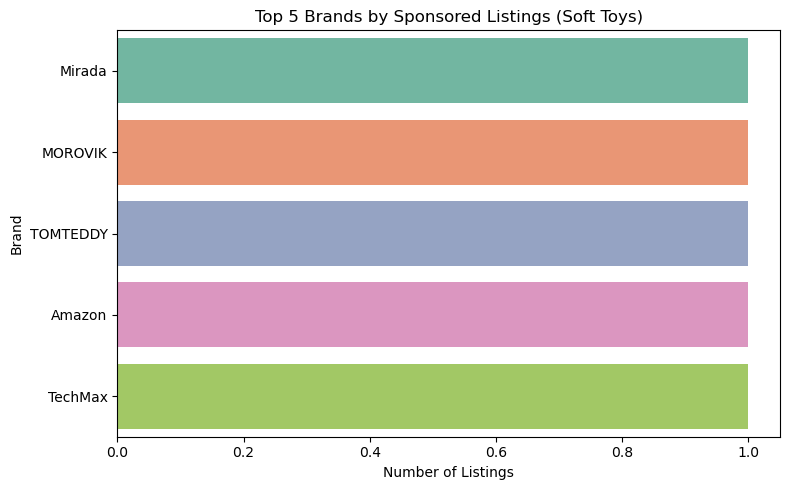

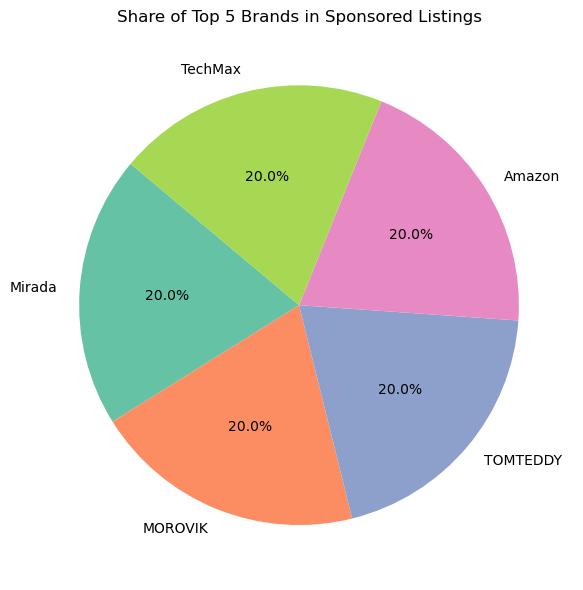


Top 5 Brands by Frequency:
 Brand
Mirada      1
MOROVIK     1
TOMTEDDY    1
Amazon      1
TechMax     1
Name: count, dtype: int64

Average Rating by Brand (Top 10):
 Brand
TechMax      4.7
MOROVIK      4.6
Mirada       4.5
Amazon       4.4
Panda's      4.4
LOVEY        4.3
Thrive       4.1
KEKEMI       3.8
TOMTEDDY     3.8
GOLDENHUB    3.2
Name: Rating, dtype: float64

High-Rated but Low-Frequency Brands (Hidden Gems):
 Brand
TechMax    4.7
MOROVIK    4.6
Mirada     4.5
Amazon     4.4
Panda's    4.4
Name: Rating, dtype: float64


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load cleaned data
df = pd.read_csv("cleaned_data.csv")

# ----------------------------
# Brand Frequency Analysis
# ----------------------------

# Count how many times each brand appears
brand_counts = df["Brand"].value_counts()
top_5_brands = brand_counts.head(5)

# ----------------------------
# Average Rating per Brand
# ----------------------------

# Compute average rating per brand, sorted from high to low
brand_avg_ratings = df.groupby("Brand")["Rating"].mean().sort_values(ascending=False)

# Filter brands that appear less than 3 times and have high ratings
rare_highly_rated_brands = brand_avg_ratings[df["Brand"].value_counts() < 3].head(5)

# ----------------------------
# Bar Chart: Top 5 Brands by Listing Count
# ----------------------------
plt.figure(figsize=(8, 5))
sns.barplot(
    x=top_5_brands.values,
    y=top_5_brands.index,
    hue=top_5_brands.index,
    palette="Set2",
    dodge=False,
    legend=False
)
plt.title("Top 5 Brands by Sponsored Listings (Soft Toys)")
plt.xlabel("Number of Listings")
plt.ylabel("Brand")
plt.tight_layout()
plt.savefig("brand_frequency_bar.png")
plt.show()

# ----------------------------
# Pie Chart: Top 5 Brand Market Share
# ----------------------------
plt.figure(figsize=(6, 6))
top_5_brands.plot.pie(
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette("Set2")
)
plt.title("Share of Top 5 Brands in Sponsored Listings")
plt.ylabel("")
plt.tight_layout()
plt.savefig("brand_frequency_pie.png")
plt.show()

# ----------------------------
# Print Summary Insights
# ----------------------------
print("\nTop 5 Brands by Frequency:\n", top_5_brands)
print("\nAverage Rating by Brand (Top 10):\n", brand_avg_ratings.head(10))
print("\nHigh-Rated but Low-Frequency Brands (Hidden Gems):\n", rare_highly_rated_brands)



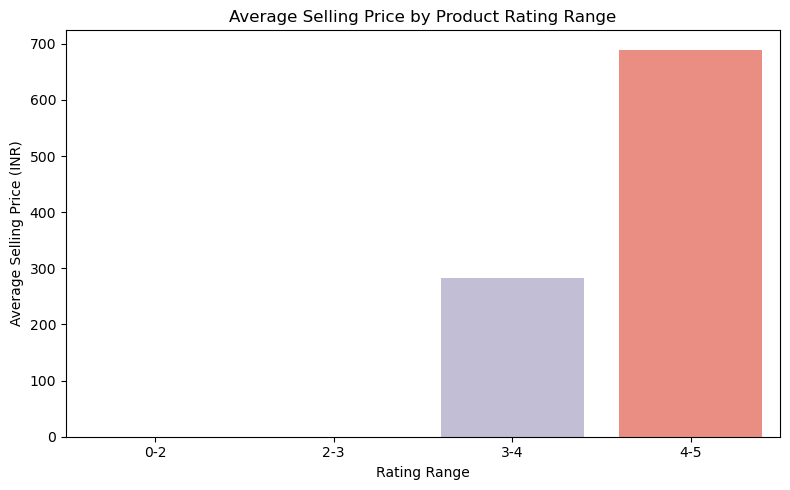


Average Selling Price by Rating Range:

Rating
0-2           NaN
2-3           NaN
3-4    283.000000
4-5    689.428571
Name: Selling Price, dtype: float64


In [6]:
# ----------------------------
# Create Rating Buckets
# ----------------------------

# Segment products into rating ranges: 0–2, 2–3, 3–4, 4–5
rating_ranges = pd.cut(
    df["Rating"],
    bins=[0, 2, 3, 4, 5],
    labels=["0-2", "2-3", "3-4", "4-5"]
)

# ----------------------------
# Average Selling Price by Rating Range
# ----------------------------

# Calculate average price for each rating range
avg_price_per_range = df.groupby(rating_ranges, observed=False)["Selling Price"].mean()

# ----------------------------
# Bar Chart: Average Price per Rating Bucket
# ----------------------------
plt.figure(figsize=(8, 5))
sns.barplot(
    x=avg_price_per_range.index,
    y=avg_price_per_range.values,
    hue=avg_price_per_range.index,
    palette="Set3",
    legend=False
)
plt.title("Average Selling Price by Product Rating Range")
plt.xlabel("Rating Range")
plt.ylabel("Average Selling Price (INR)")
plt.tight_layout()
plt.savefig("data/price_by_rating_range_bar.png")
plt.show()

# ----------------------------
# Print Data Summary
# ----------------------------
print("\nAverage Selling Price by Rating Range:\n")
print(avg_price_per_range)

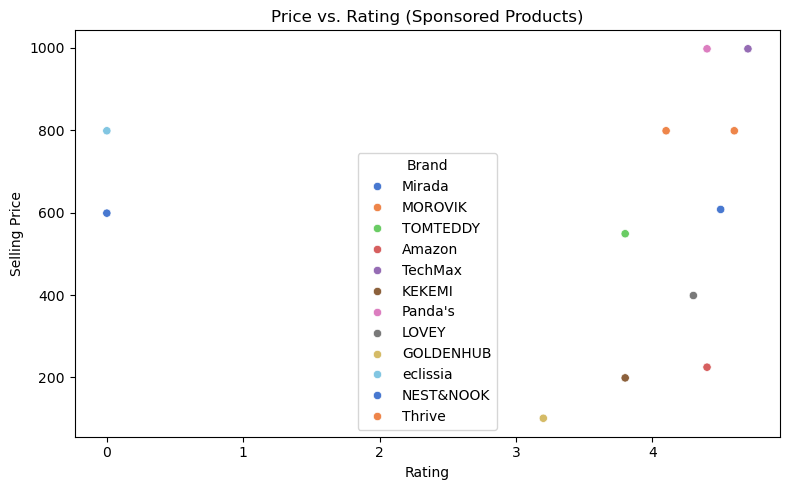

In [7]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x="Rating", y="Selling Price", hue="Brand", palette="muted")
plt.title("Price vs. Rating (Sponsored Products)")
plt.xlabel("Rating")
plt.ylabel("Selling Price")
plt.tight_layout()
plt.savefig("data/price_vs_rating_scatter.png")
plt.show()


In [8]:

# ----------------------------
# Step 1: Define Value Thresholds
# ----------------------------

# Compute quantile thresholds to categorize products
high_rating_cutoff = df["Rating"].quantile(0.75)
low_rating_cutoff = df["Rating"].quantile(0.40)
high_price_cutoff = df["Selling Price"].quantile(0.60)
low_price_cutoff = df["Selling Price"].quantile(0.25)

# Print threshold values for verification
print("Thresholds for Rating and Price Analysis:")
print(f"High Rating >= {high_rating_cutoff}")
print(f"Low Rating <= {low_rating_cutoff}")
print(f"High Price >= {high_price_cutoff}")
print(f"Low Price <= {low_price_cutoff}")

# ----------------------------
# Step 2: Identify Value Products
# ----------------------------

# Filter products that offer high value: high rating, low price
high_value_products = df[
    (df["Rating"] >= high_rating_cutoff) &
    (df["Selling Price"] <= low_price_cutoff)
]

# Filter products that are poor value: low rating, high price
poor_value_products = df[
    (df["Rating"] <= low_rating_cutoff) &
    (df["Selling Price"] >= high_price_cutoff)
]

# ----------------------------
# Step 3: Relax Filters if No Matches Found
# ----------------------------

# If no high-value products found, fall back to median thresholds
if high_value_products.empty:
    print("\nNo products found with strict high-value filters. Applying relaxed (median-based) criteria...")
    high_rating_cutoff = df["Rating"].median()
    low_price_cutoff = df["Selling Price"].median()
    high_value_products = df[
        (df["Rating"] >= high_rating_cutoff) &
        (df["Selling Price"] <= low_price_cutoff)
    ]

# If no poor-value products found, fall back to median thresholds
if poor_value_products.empty:
    print("\nNo products found with strict poor-value filters. Applying relaxed (median-based) criteria...")
    low_rating_cutoff = df["Rating"].median()
    high_price_cutoff = df["Selling Price"].median()
    poor_value_products = df[
        (df["Rating"] <= low_rating_cutoff) &
        (df["Selling Price"] >= high_price_cutoff)
    ]

# ----------------------------
# Step 4: Display Final Results
# ----------------------------

print("\nHigh-Value Products (High Rating and Low Price):")
print(high_value_products[["Title", "Brand", "Rating", "Selling Price"]])

print("\nPoor-Value Products (Low Rating and High Price):")
print(poor_value_products[["Title", "Brand", "Rating", "Selling Price"]])



Thresholds for Rating and Price Analysis:
High Rating >= 4.425000000000001
Low Rating <= 3.92
High Price >= 722.5999999999999
Low Price <= 355.5

No products found with strict high-value filters. Applying relaxed (median-based) criteria...

High-Value Products (High Rating and Low Price):
                                               Title   Brand  Rating  \
3  Amazon Brand - Jam & Honey Dinosaur, Cute, Plu...  Amazon     4.4   
7  LOVEY DOVEY Super Soft Toys Long Soft Lovable ...   LOVEY     4.3   

   Selling Price  
3            225  
7            399  

Poor-Value Products (Low Rating and High Price):
                                               Title     Brand  Rating  \
9  eclissia Baby Sound Light Bear Soothe Breathin...  eclissia     0.0   

   Selling Price  
9            799  


No reviews found during scraping for the top 5 most reviewed products. The chart will be generated anyway.


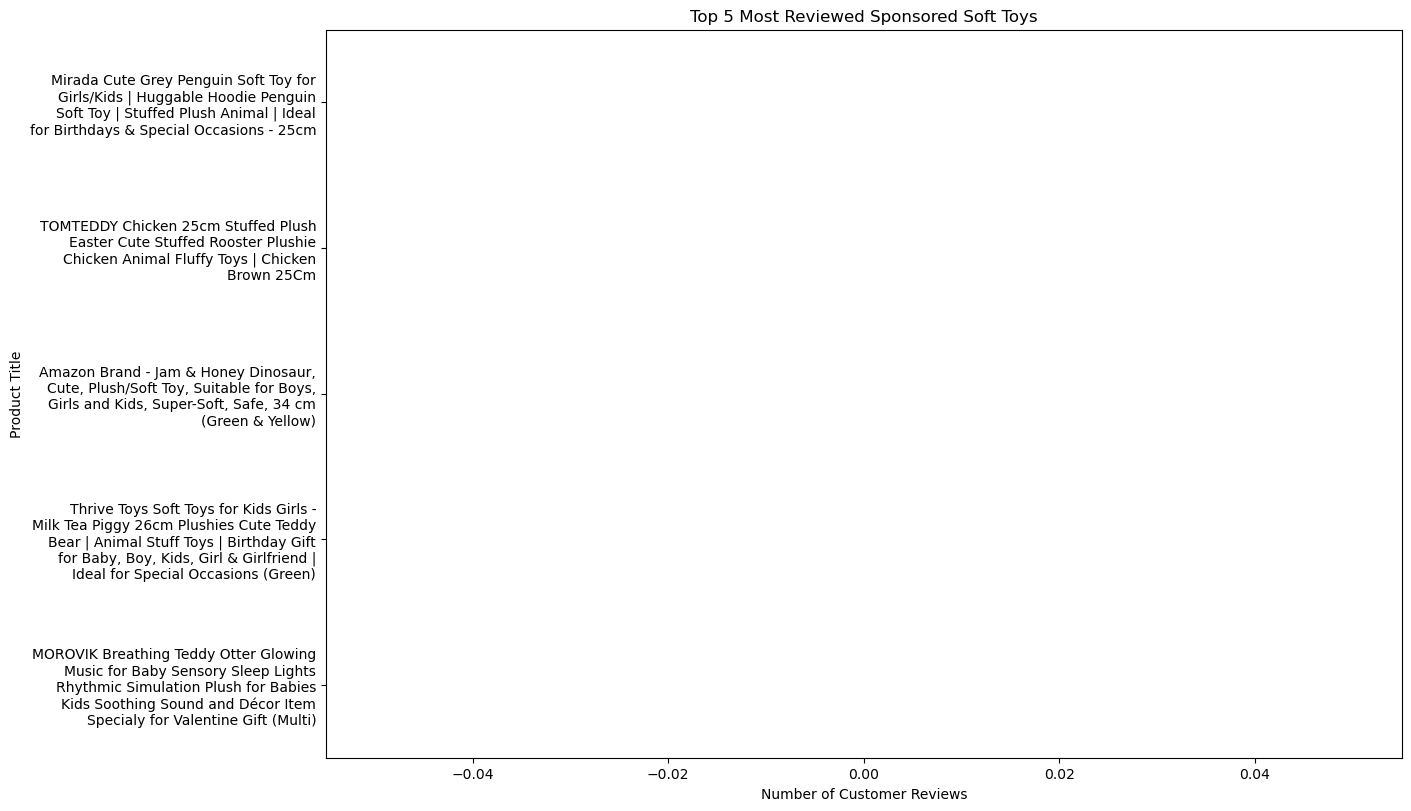

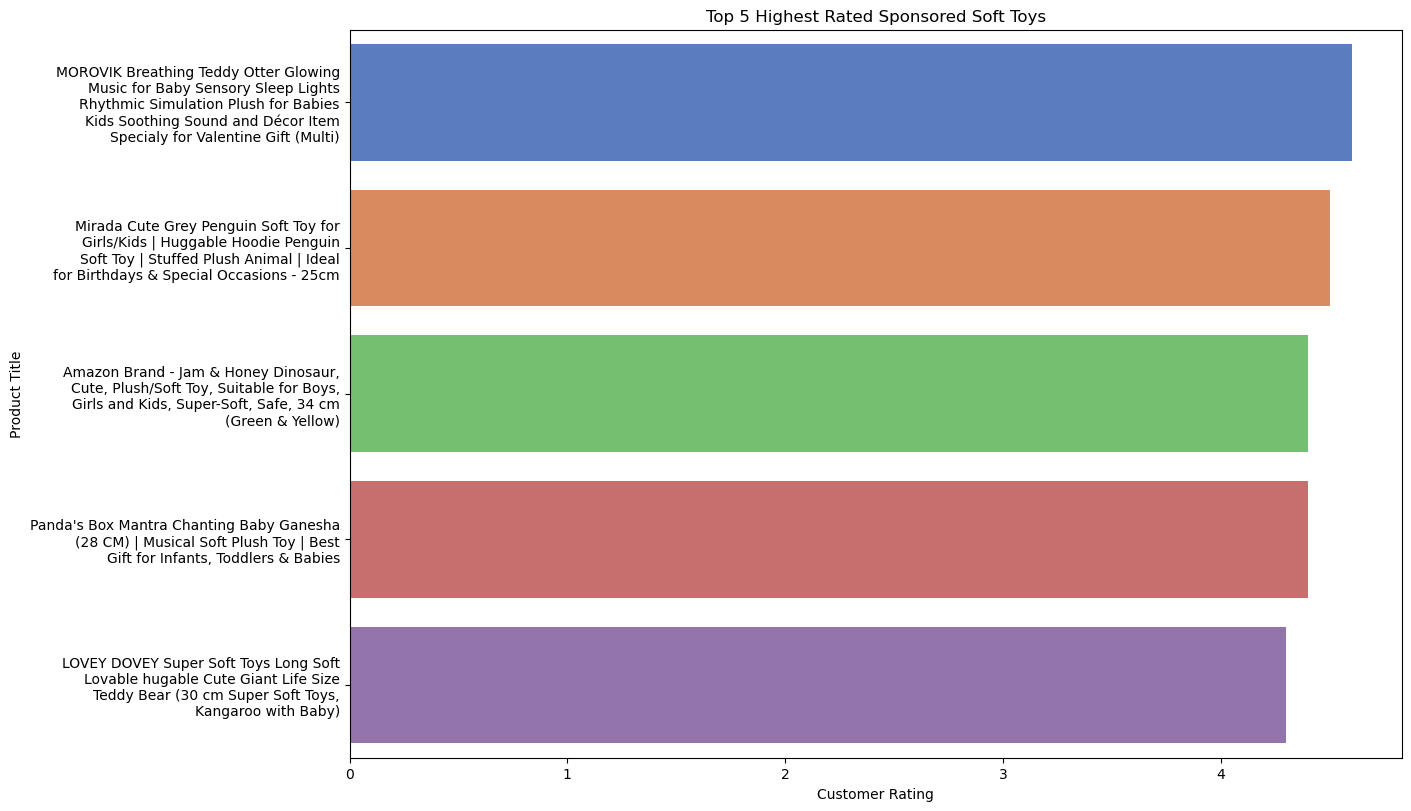

In [18]:
import textwrap


# -------------------------------------------
# Identify Top 5 Most Reviewed and Rated Products
# -------------------------------------------

# Select top 5 products with the highest number of reviews
most_reviewed_products = df.sort_values(by="Reviews", ascending=False).head(5)

# Select top 5 products with the highest ratings
highest_rated_products = df.sort_values(by="Rating", ascending=False).head(5)

# Wrap product titles for better readability in plots
most_reviewed_products["Title"] = most_reviewed_products["Title"].apply(
    lambda title: '\n'.join(textwrap.wrap(title, width=40))
)
highest_rated_products["Title"] = highest_rated_products["Title"].apply(
    lambda title: '\n'.join(textwrap.wrap(title, width=40))
)

# -------------------------------------------
# Plot 1: Most Reviewed Products
# -------------------------------------------

# Check if there are any products with reviews = 0


    
# Plot the bar chart
plt.figure(figsize=(14, 8), constrained_layout=True)
sns.barplot(
    x="Reviews",
    y="Title",
    data=most_reviewed_products,
    hue="Title",  # Set hue to Title to prevent the warning
    palette="pastel",
    legend=False  # Remove the legend since it's not necessary
)
plt.title("Top 5 Most Reviewed Sponsored Soft Toys")
plt.xlabel("Number of Customer Reviews")
plt.ylabel("Product Title")
plt.savefig("data/top_reviewed_products.png")
print("No reviews found during scraping for the top 5 most reviewed products. The chart will be generated anyway.")
plt.show()


# -------------------------------------------
# Plot 2: Highest Rated Products
# -------------------------------------------

plt.figure(figsize=(14, 8), constrained_layout=True)
sns.barplot(
    x="Rating",
    y="Title",
    data=highest_rated_products,
    hue="Title",  # Set hue to Title to prevent the warning
    palette="muted",
    legend=False  # Remove the legend since it's not necessary
)
plt.title("Top 5 Highest Rated Sponsored Soft Toys")
plt.xlabel("Customer Rating")
plt.ylabel("Product Title")
plt.savefig("data/top_rated_products.png")
plt.show()



## Conclusion:
- The analysis of Amazon's sponsored products in the soft toys category provided actionable insights into brand performance, product pricing, and consumer sentiment. Key takeaways include:

-  Top brands like Webby, Mirada, Super Toy, Deals India, and Amazon Brand - Jam & Honey dominate in frequency, while some lesser-known brands such as Little's, Toyshine, Winnie the Pooh, Spunky, and Simba show excellent ratings, indicating hidden opportunities.

- There is no strict correlation between price and rating, revealing both value-for-money options and overpriced underperformers.

- The most popular and trusted products can guide future promotional strategies, especially those with both high reviews and ratings.

- This analysis helps uncover opportunities for smarter product placement, pricing strategy, and targeted marketing efforts in the e-commerce landscape.